In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
PATH = os.path.abspath("40000_5_100_2_0.npy")

In [3]:
data = np.load(PATH, allow_pickle=True)
print(data.shape)

(40000, 5, 100, 2)


In [4]:
def plot_values(m, n_examples=2, rand=True):
    fig, axarr = plt.subplots(ncols=n_examples, nrows=2, figsize=(30, 10))
    indices = range(n_examples) if not rand else np.random.randint(0, len(data), size=(n_examples))
    for i, index in enumerate(indices):
        for atom_i in range(m.shape[1]):
            axarr[0, i].plot(m[index, atom_i, :, 0])
            axarr[1, i].plot(m[index, atom_i, :, 1])

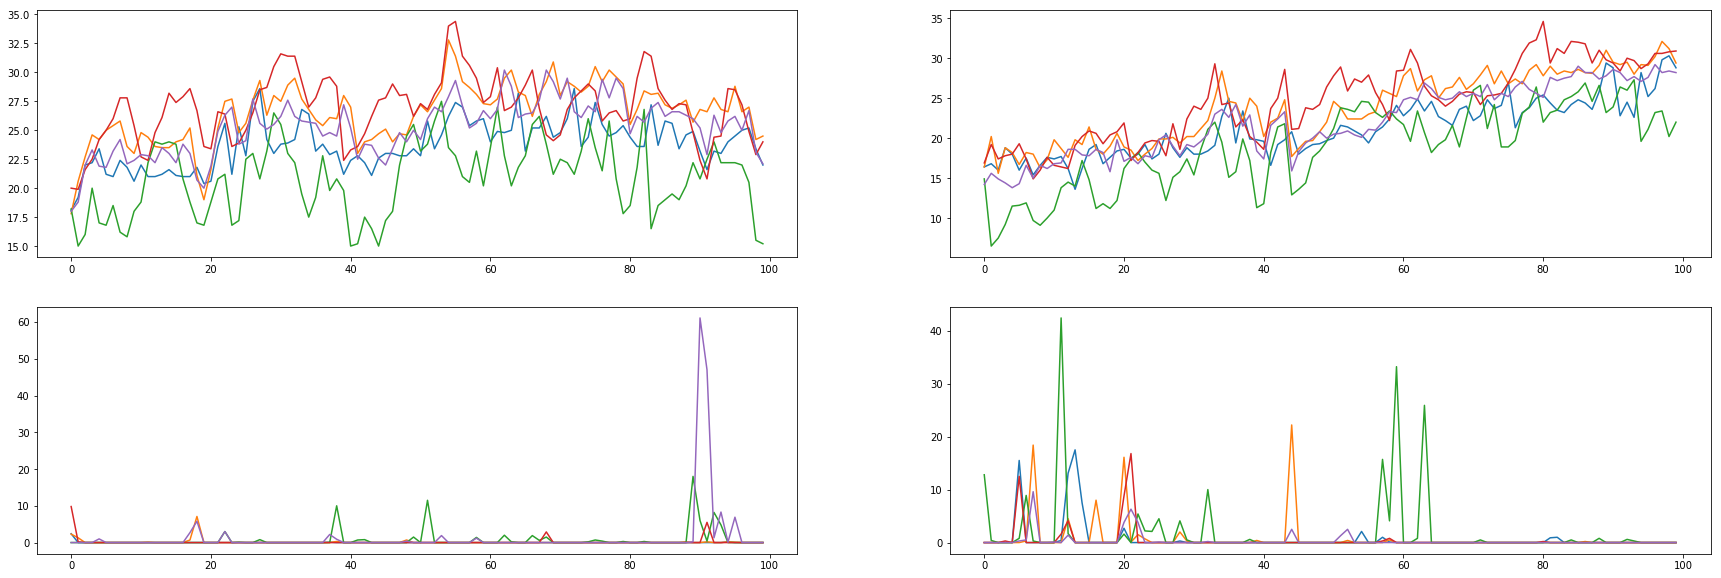

In [5]:
plot_values(data, rand=False)

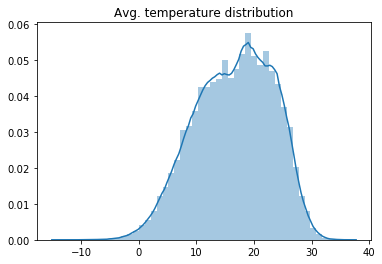

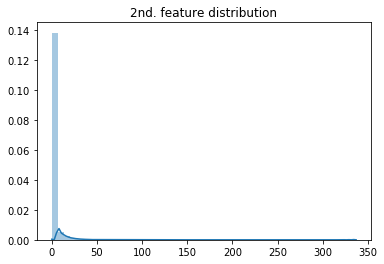

In [6]:
plt.title("Avg. temperature distribution")
sns.distplot(data[:, :, :, 0].flatten())
plt.figure()
plt.title("2nd. feature distribution")
sns.distplot(data[:, :, :, 1].flatten())

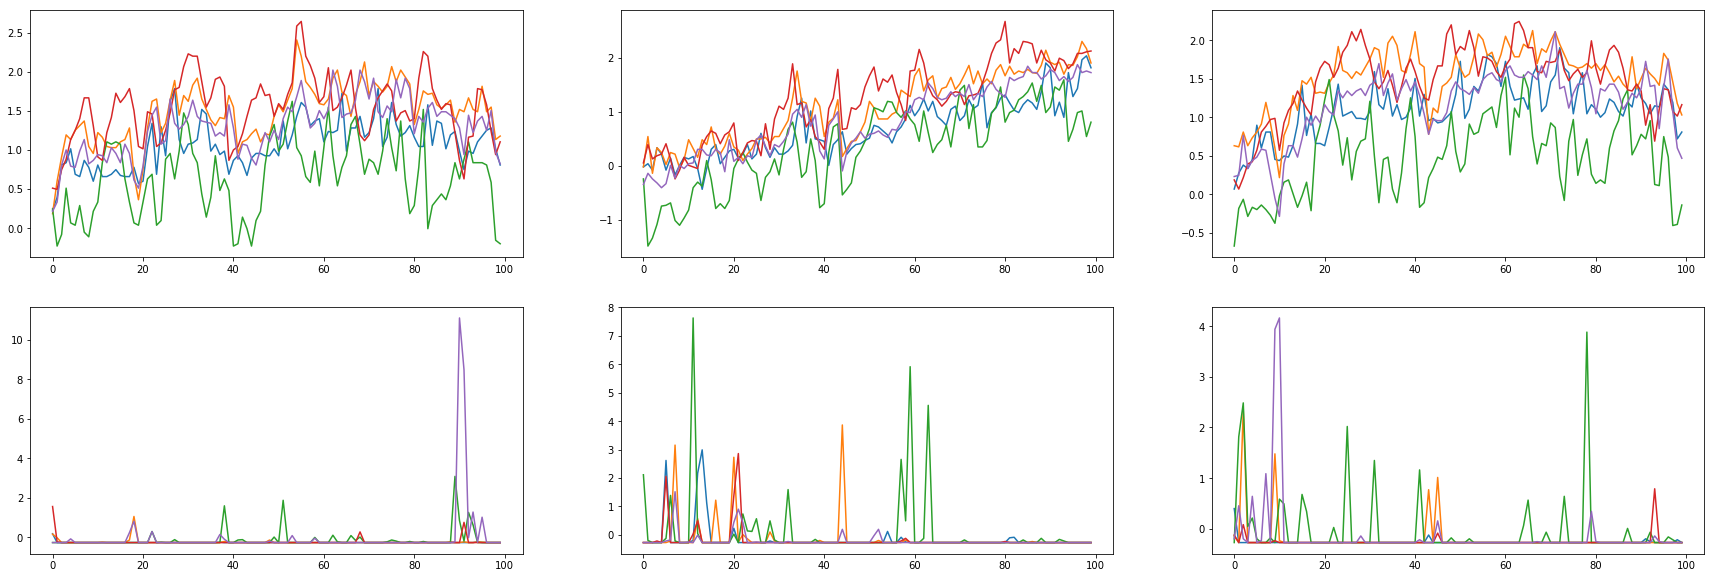

In [28]:
mean_temp = data[:, :, :, 0].mean()
std_temp = data[:, :, :, 0].std()
mean_humid = data[:, :, :, 1].mean()
std_humid = data[:, :, :, 1].std()

data_norm = data.copy()
data_norm[:,:,:,0] = (data_norm[:,:,:,0] - mean_temp) / std_temp
data_norm[:,:,:,1] = (data_norm[:,:,:,1] - mean_humid) / std_humid
plot_values(data_norm, n_examples=3, rand=False)

Stations interactions for first Example


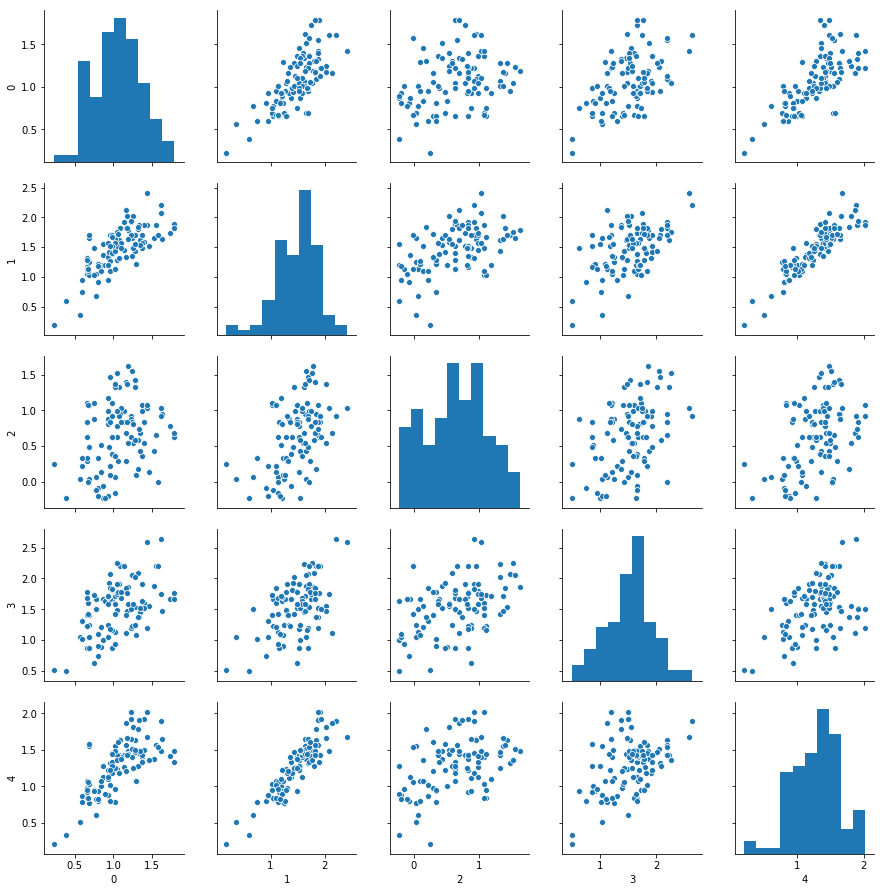

In [41]:
print("Stations interactions for first Example")
sns.pairplot(pd.DataFrame(data_norm[0, :, :, 0]).swapaxes(0, 1))

In [30]:
def exp_moving_avg(data, beta=0.3):
    smoothed = data.copy()
    timesteps = data.shape[2]
    for step in range(1, timesteps):
        smoothed[:, :, step, :] = beta * data[:, :, step, :] + (1 - beta) * smoothed[:, :, step - 1, :]
    return smoothed

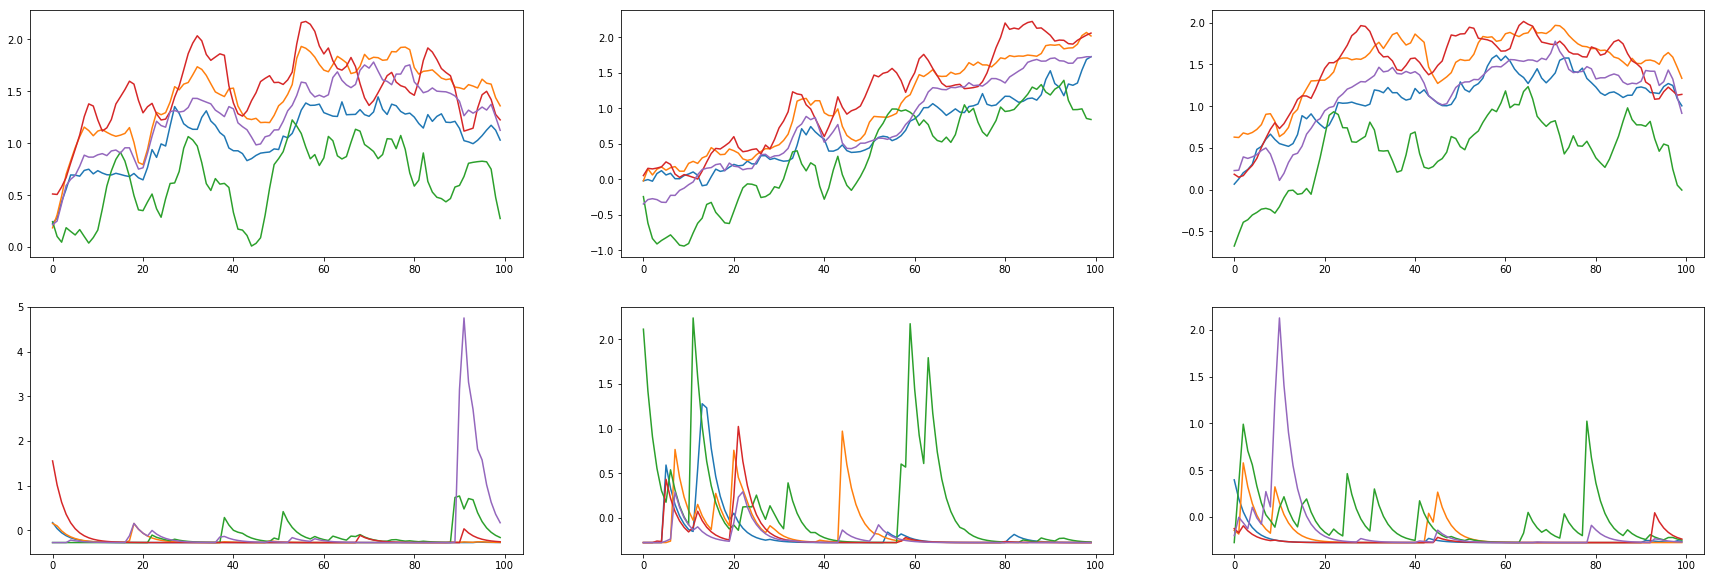

In [31]:
data_smoothed = exp_moving_avg(data_norm)
plot_values(data_smoothed, n_examples=3, rand=False)

In [44]:
def moving_avg(data, window_size=3):
    assert window_size % 2 == 1, "Only symmetric windows allowed."
    smoothed = data.copy()
    timesteps = data.shape[2]
    start_i = window_size // 2
    print(f"Starting at {start_i} with window size {window_size}")
    for step in range(start_i, timesteps - start_i):
        val = sum([data[:, :, step - (start_i) + i] for i in range(window_size)]) / window_size
        smoothed[:, :, step, :] = val
    return smoothed

In [56]:
x = np.asanyarray([[[0.0, 1.0, 2.0, 3.0, 2.0, 1.0, 0.0]]])
x = x[:,:,:,np.newaxis]
x_smoothed = moving_avg(x, window_size=3)

Starting at 1 with window size 3


In [52]:
print((moving_avg(data, window_size=1) == data).all())
print(not (moving_avg(data, window_size=3) == data).all())

Starting at 0 with window size 1
True
Starting at 1 with window size 3
True


Starting at 1 with window size 3


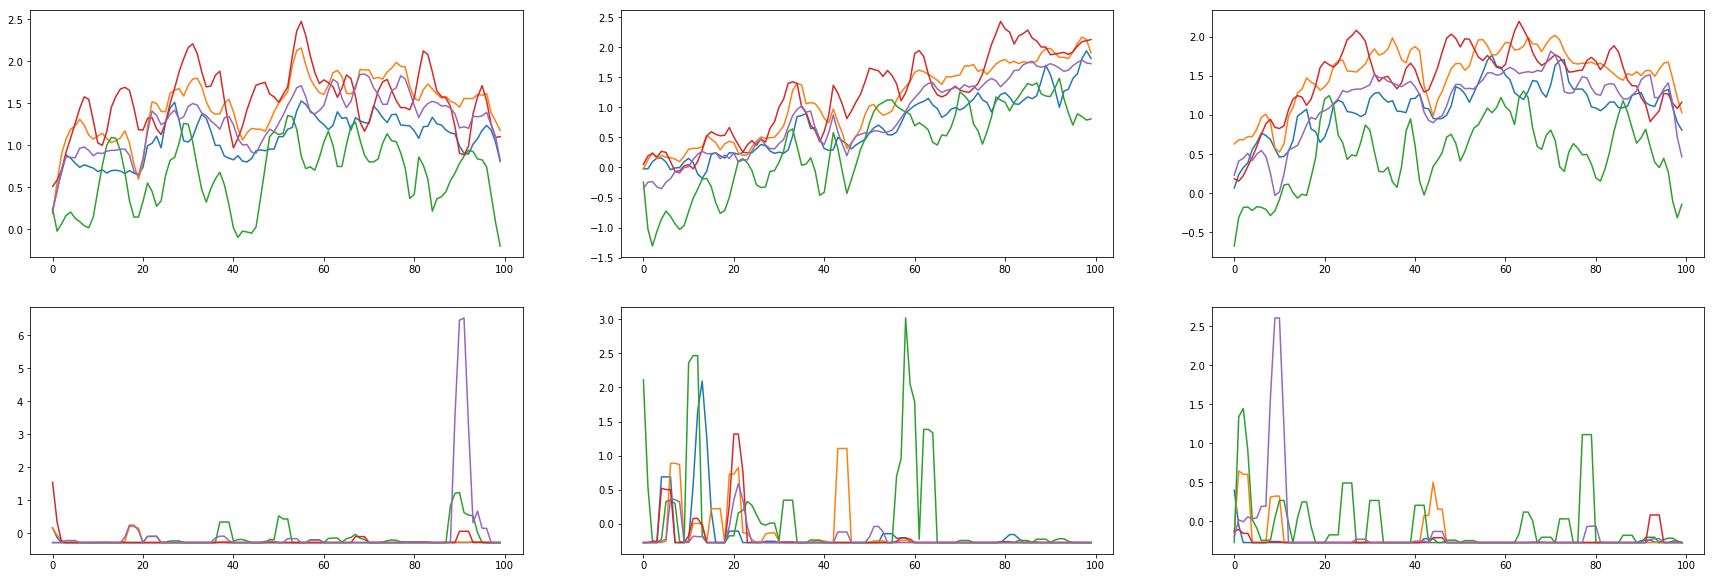

In [58]:
data_smoothed = moving_avg(data_norm, window_size=3)
plot_values(data_smoothed, n_examples=3, rand=False)

Starting at 4 with window size 9


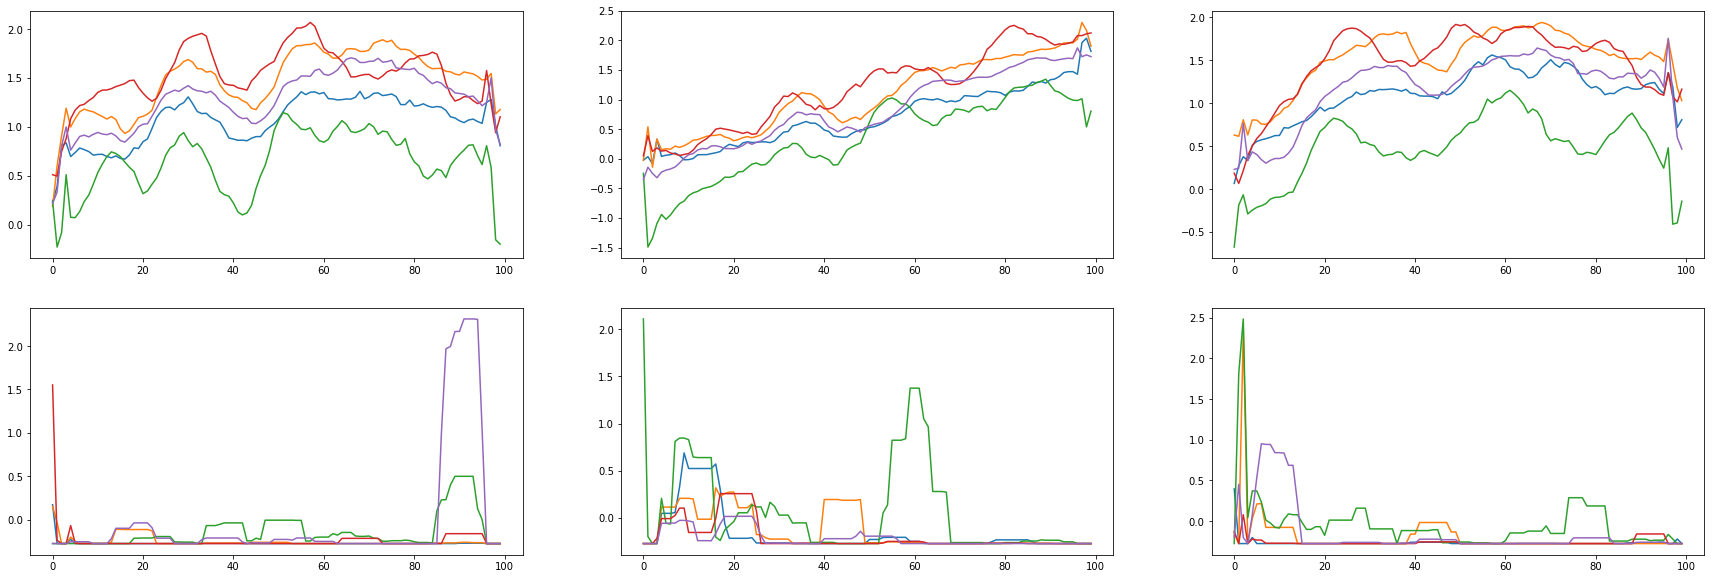

In [50]:
data_smoothed = moving_avg(data_norm, window_size=9)
plot_values(data_smoothed, n_examples=3, rand=False)

In [69]:
def save_dataset(filename, data):
    print(f"Saving smoothed data under name {new_filename}")
    np.save(filename, data, allow_pickle=True)

def smooth_and_save(path, smoothing_function):
    print(f"Loaded data from path {path}")
    data = np.load(path, allow_pickle=True)
    
    print(f"Smoothing data with {smoothing_function.__name__}")
    data_smoothed = smoothing_function(data)
    
    new_filename = path.split(".npy")[0] + "_smoothed.npy" 
    save_dataset(new_filename, data_smoothed)

In [68]:
smooth_and_save(PATH, exp_moving_avg)

Loaded data from path /nfs/students/summer-term-2019/project-4/datasets/weather/40000_5_100_2_0.npy
Smoothing data with exp_moving_avg
Saving smoothed data under name /nfs/students/summer-term-2019/project-4/datasets/weather/40000_5_100_2_0_smoothed.npy
